In [3]:
from typing import TypedDict

In [4]:
class EmotionState(TypedDict):
    user_input: str
    sentiment: str
    final_response: str

In [5]:
def get_user_input(state: EmotionState) -> EmotionState:
    return state

In [6]:
from langchain_core.runnables import Runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [7]:
llm = ChatOpenAI(model='gpt-4o')

sentiment_prompt = ChatPromptTemplate.from_messages([
    ('system', '너는 사용자의 문장을 감정적으로 분류하는 도우미야. 감정은 반드시 다음 중 하나여야 해: positive, negative, neutral.'),
    ('human', '다음 문장의 감정을 분류해 줘: {text}')
])

In [8]:
sentiment_chain = sentiment_prompt | llm

In [9]:
def analyze_sentiment(state: EmotionState) -> EmotionState:
    text = state['user_input']

    response = sentiment_chain.invoke({'text': text})
    sentiment = response.content.strip().lower()

    if sentiment not in ['positive', 'negative', 'neutral']:
        sentiment = 'neutral'
        
    return {'sentiment': sentiment}


In [10]:
def decide_next_node(state: EmotionState) -> str:
    return state['sentiment']

In [11]:
def generate_congrats_response(state: EmotionState) -> EmotionState:
    return {'final_response': '정말 축하해요!!!'}

def generate_encouragement_response(state: EmotionState) -> EmotionState:
    return {'final_response': '힘내자!!!'}

def generate_neutral_response(state: EmotionState) -> EmotionState:
    return {'final_response': '그랬구나'}

In [12]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(EmotionState)

builder.add_node(get_user_input)
builder.add_node(analyze_sentiment)
builder.add_node(generate_congrats_response)
builder.add_node(generate_encouragement_response)
builder.add_node(generate_neutral_response)

builder.add_edge(START, 'get_user_input')
builder.add_edge('get_user_input', 'analyze_sentiment')

builder.add_conditional_edges(
    'analyze_sentiment',
    decide_next_node,
    {
        'positive': 'generate_congrats_response',
        'negative': 'generate_encouragement_response',
        'neutral': 'generate_neutral_response'
    }
)

builder.add_edge('generate_congrats_response', END)
builder.add_edge('generate_encouragement_response', END)
builder.add_edge('generate_neutral_response', END)

graph = builder.compile()

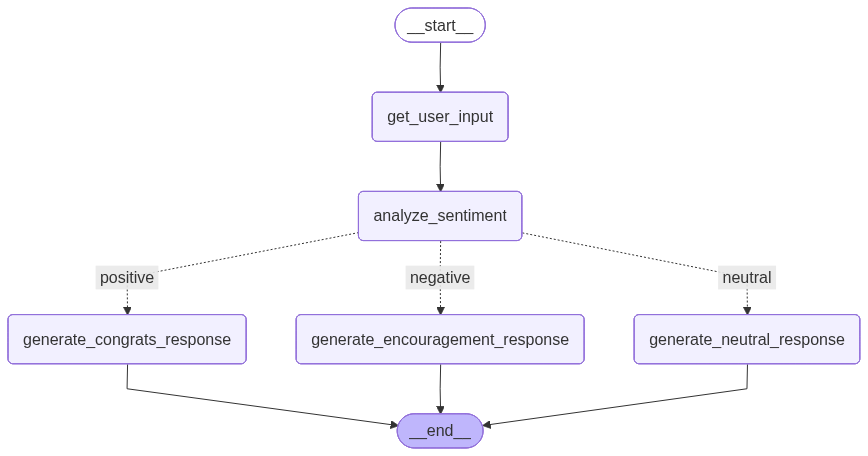

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
inputs = {'user_input': '나 오늘 집에 안갈래'}
result = graph.invoke(inputs)

print('최종 결과: ', result['final_response'])

최종 결과:  그랬구나
